> Fullname: Yiming Zhang 
> Student ID: 35224436

## <span style="color:#0b486b">Part 2: Deep Neural Networks (DNN) </span>
<div style="text-align: right"><span style="color:red; font-weight:bold">[Total marks for this part: 25 points]<span></div>

The second part of this assignment is to demonstrate your basis knowledge in deep learning that you have acquired from the lectures and tutorials materials. Most of the contents in this assignment are drawn from **the tutorials covered from weeks 1 to 2**. Going through these materials before attempting this assignment is highly recommended.

In the second part of this assignment, you are going to work with the FashionMNIST dataset for the image recognition task. It has the exact same format as MNIST (70,000 grayscale images of 28 × 28 pixels each with 10 classes), but the images represent fashion items rather than handwritten digits, so each class is more diverse, and the problem is significantly more challenging than MNIST.

In [79]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

torch.manual_seed(1234)

**Load the Fashion MNIST using `torchvision`**

In [80]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_dataset_orgin = datasets.FashionMNIST(root='./data', train=True, download=False, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=False, transform=transform)

print(train_dataset_orgin.data.shape, train_dataset_orgin.targets.shape)
print(test_dataset.data.shape, test_dataset.targets.shape)

# Flatten the data
train_dataset_orgin.data = train_dataset_orgin.data.reshape(-1, 28*28)
test_dataset.data = test_dataset.data.reshape(-1, 28*28)

print(train_dataset_orgin.data.shape, train_dataset_orgin.targets.shape)
print(test_dataset.data.shape, test_dataset.targets.shape)

N = len(train_dataset_orgin)
print(f"Number of training samples: {N}")
N_train = int(0.9*N)
N_val = N - N_train
print(f"Number of training samples: {N_train}")
print(f"Number of validation samples: {N_val}")

train_dataset, val_dataset = torch.utils.data.random_split(train_dataset_orgin, [N_train, N_val])


print(len(train_dataset))
print(len(val_dataset))


train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=1000, shuffle=False)


torch.Size([60000, 28, 28]) torch.Size([60000])
torch.Size([10000, 28, 28]) torch.Size([10000])
torch.Size([60000, 784]) torch.Size([60000])
torch.Size([10000, 784]) torch.Size([10000])
Number of training samples: 60000
Number of training samples: 54000
Number of validation samples: 6000
54000
6000


####  <span style="color:red">**Question 2.1:**</span> Write the code to visualize a mini-batch in `train_loader` including its images and labels.

<div style="text-align: right"> <span style="color:red">[5 points]</span> </div>

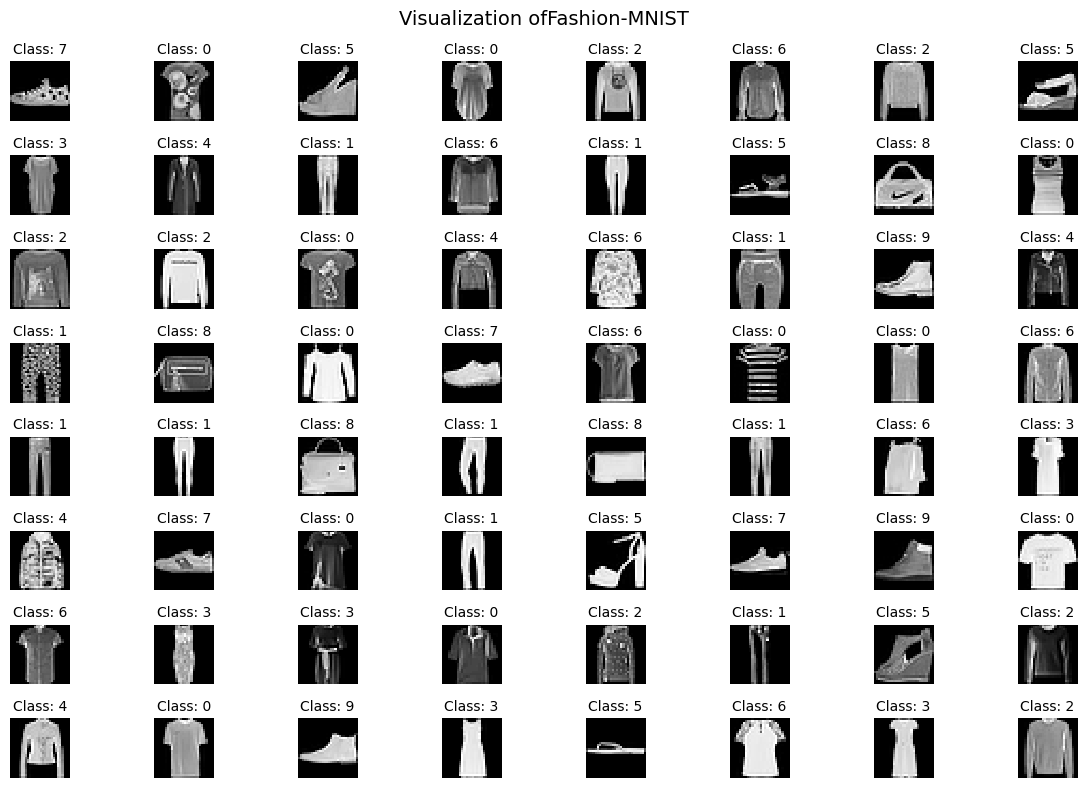

In [81]:
# Your code here
import matplotlib.pyplot as plt


def visualize_images(loader, batch_size=64):
    """
    Visualize the images in the loader
    batch_size: the number of images to show
    """
    images, labels = next(iter(loader))

    cols = int(batch_size**0.5)
    rows = (batch_size + cols - 1) // cols

    plt.figure(figsize=(12, 8))
    for idx in range(min(batch_size, len(images))):
        plt.subplot(rows, cols, idx + 1)
        # reshape the image to 28x28
        image = images[idx].detach().numpy().reshape(28, 28)
        plt.imshow(image, cmap="gray", interpolation="nearest")
        plt.title(f"Class: {labels[idx].item()}", fontsize=10)
        plt.axis("off")

    plt.suptitle("Visualization ofFashion-MNIST", fontsize=14, y=0.98)
    plt.tight_layout()
    plt.show()


visualize_images(train_loader)

#### <span style="color:red">**Question 2.2:**</span> Write the code for the feed-forward neural net using PyTorch

<div style="text-align: right"> <span style="color:red">[5 points]</span> </div>

We now develop a feed-forward neural network with the architecture $784 \rightarrow 40(ReLU) \rightarrow 30(ReLU) \rightarrow 10(softmax)$. You can choose your own way to implement your network and an optimizer of interest. You should train model in $50$ epochs and evaluate the trained model on the test set.

##### FFN Class

In [82]:
# Your code here
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam


# ===== Model =====
class FFN(nn.Module):
    def __init__(self):
        super(FFN, self).__init__()
        self.fc1 = nn.Linear(784, 40)
        self.fc2 = nn.Linear(40, 30)
        self.fc3 = nn.Linear(30, 10)

    def forward(self, x):
        # flatten the image to 28*28
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        logits = F.softmax(self.fc3(x), dim=1) # (B, 10)
        return logits



##### Initialize the model

In [83]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FFN().to(device)
model

FFN(
  (fc1): Linear(in_features=784, out_features=40, bias=True)
  (fc2): Linear(in_features=40, out_features=30, bias=True)
  (fc3): Linear(in_features=30, out_features=10, bias=True)
)

##### Define loss function and optimizer

In [84]:
criterion = nn.CrossEntropyLoss() # cross entropy loss
optimizer = Adam(model.parameters(), lr=1e-3) # Adam optimizer

##### Training function

In [85]:
def run_epoch(model, loader, train=True, criterion=None, optimizer=None):
    model.train(mode=train)
    total_loss, total_correct, total_samp = 0.0, 0, 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        logits = model(images)
        loss = criterion(logits, labels)

        if train:  # only update the model parameters when training
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        total_loss += loss.item() * images.size(0)
        preds = logits.argmax(dim=1)
        total_correct += (preds == labels).sum().item()
        total_samp += images.size(0)

    avg_loss = total_loss / total_samp
    acc = total_correct / total_samp
    return avg_loss, acc

##### Training process

In [ ]:
# ===== Training loop (50 epochs) =====
print("Training...\n")
EPOCHS = 50
for epoch in range(1, EPOCHS + 1):
    train_loss, train_acc = run_epoch(
        model, train_loader, train=True, criterion=criterion, optimizer=optimizer
    )
    valid_loss, valid_acc = run_epoch(
        model, val_loader, train=False, criterion=criterion, optimizer=optimizer
    )

    print(
        f"Epoch {epoch}/{EPOCHS}, "
        f"Train loss {train_loss:.4f} acc {(train_acc*100):.2f}%, "
        f"Valid loss {valid_loss:.4f} acc {(valid_acc*100):.2f}%"
    )
print("Training done!")
# Test the model with test set
print(f"\nTesting Result:")
test_loss, test_acc = run_epoch(
    model,
    test_loader,
    train=False,
    criterion=criterion,
    optimizer=optimizer,
)
print(f"Test loss: {test_loss:.4f}, Valid acc: {(test_acc*100):.2f}")

####  <span style="color:red">**Question 2.3:**</span> Tuning hyper-parameters with grid search
<div style="text-align: right"> <span style="color:red">[5 points]</span> </div>


Assume that you need to tune the number of neurons on the first and second hidden layers $n_1 \in \{20, 40\}$, $n_2 \in \{20, 40\}$  and the used activation function  $act \in \{sigmoid, tanh, relu\}$. The network has the architecture pattern $784 \rightarrow n_1 (act) \rightarrow n_2(act) \rightarrow 10(softmax)$ where $n_1, n_2$, and $act$ are in their grides. Write the code to tune the hyper-parameters $n_1, n_2$, and $act$. Note that you can freely choose the optimizer and learning rate of interest for this task.

In [ ]:
# Your code here
class tunable_FFN(nn.Module):
    """FNN can be tuned by changing the number of neurons and the activation function"""

    def __init__(self, n1, n2, act):
        super(tunable_FFN, self).__init__()
        self.fc1 = nn.Linear(784, n1)
        self.fc2 = nn.Linear(n1, n2)
        self.fc3 = nn.Linear(n2, 10)
        self.act = act

    def forward(self, x):
        # flatten the image to 28*28
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        logits = F.softmax(self.fc3(x), dim=1)  # (B, 10)
        return logits


EPOCHS_TUNE = 50
# store the results of each hyper-parameter combination (n1, n2, act, valid_loss, valid_acc, test_loss, test_acc)
results = []
best_config = None  # store the best config for question 2.5


def train_on_epoch(model, loader, criterion, optimizer, train=True):
    """Train the model for each epoch"""
    model.train(mode=train)
    loss_epoch, acc_epoch, samp_epoch = 0.0, 0, 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        logits = model(images)
        loss = criterion(logits, labels)

        if train:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        loss_epoch += loss.item() * images.size(0)
        preds = logits.argmax(dim=1)
        acc_epoch += (preds == labels).sum().item()
        samp_epoch += images.size(0)

    train_loss_epoch = loss_epoch / samp_epoch  # loss of the epoch
    train_acc_epoch = acc_epoch / samp_epoch  # accuracy of the epoch
    return train_loss_epoch, train_acc_epoch


def train_model(model, criterion, optimizer):
    """Train the model with different hyper-parameters"""
    for epoch in range(1, EPOCHS_TUNE + 1):
        train_loss, train_acc = train_on_epoch(
            model, train_loader, criterion, optimizer, train=True
        )
        valid_loss, valid_acc = train_on_epoch(
            model, test_loader, criterion, optimizer, train=False
        )
        print(
            f"Epoch {epoch}/{EPOCHS_TUNE}, "
            f"Train loss {train_loss:.4f} acc {(train_acc*100):.2f}%, "
            f"Valid loss {valid_loss:.4f} acc {(valid_acc*100):.2f}%"
        )

    return valid_loss, valid_acc


def evaluate(model=None):
    """test the model on the test set"""
    optimizer = Adam(model.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()
    test_loss, test_acc = train_on_epoch(
        model, test_loader, criterion, optimizer, train=False
    )
    print(f"test_loss={test_loss:.4f}, test_acc={(test_acc*100):.2f}%")
    return test_loss, test_acc


def fine_tune():
    global best_config, results
    """Fine-tune the model with different hyper-parameters"""
    n1_grid = [20, 40]
    n2_grid = [20, 40]
    act_grid = [F.sigmoid, F.tanh, F.relu]
    print("Start tuning...")
    for n1 in n1_grid:
        for n2 in n2_grid:
            for act in act_grid:
                print(f"\n[Config] n1 = {n1}, n2 = {n2}, act = {act.__name__}")
                model = tunable_FFN(n1, n2, act).to(device)
                optimizer = Adam(model.parameters(), lr=1e-3)
                criterion = nn.CrossEntropyLoss()
                valid_loss, valid_acc = train_model(model, criterion, optimizer)
                test_loss, test_acc = evaluate(model)
                results.append(
                    (n1, n2, act, valid_loss, valid_acc, test_loss, test_acc)
                )
    print("Tuning done!")

    # find the best config and model by max test_acc
    best_config = max(results, key=lambda x: x[6])
    n1, n2, act, _, _, _, best_acc = best_config
    print(
        f"Best config:",
        f"\nNetwork architecture: 784 -> {n1} -> {n2} -> 10",
        f"\nActivation function: {act.__name__}",
        f"\nBest accuracy: {best_acc*100:.2f}%",
    )


fine_tune()

Start tuning...

[Config] n1 = 20, n2 = 20, act = sigmoid
Epoch 1/10, Train loss 1.8330 acc 64.20%, Valid loss 1.7882 acc 67.36%
Epoch 2/10, Train loss 1.7559 acc 70.79%, Valid loss 1.7258 acc 73.73%
Epoch 3/10, Train loss 1.7036 acc 76.02%, Valid loss 1.7107 acc 75.24%
Epoch 4/10, Train loss 1.6949 acc 76.75%, Valid loss 1.7041 acc 75.84%
Epoch 5/10, Train loss 1.6900 acc 77.20%, Valid loss 1.7039 acc 75.83%
Epoch 6/10, Train loss 1.6854 acc 77.64%, Valid loss 1.7018 acc 75.97%
Epoch 7/10, Train loss 1.6834 acc 77.81%, Valid loss 1.6950 acc 76.55%
Epoch 8/10, Train loss 1.6799 acc 78.10%, Valid loss 1.6975 acc 76.27%
Epoch 9/10, Train loss 1.6788 acc 78.22%, Valid loss 1.6941 acc 76.62%
Epoch 10/10, Train loss 1.6755 acc 78.55%, Valid loss 1.6935 acc 76.60%
test_loss=1.6935, test_acc=76.60%

[Config] n1 = 20, n2 = 20, act = tanh
Epoch 1/10, Train loss 1.7684 acc 70.72%, Valid loss 1.6816 acc 78.65%
Epoch 2/10, Train loss 1.6670 acc 79.87%, Valid loss 1.6680 acc 79.63%
Epoch 3/10, Trai

####  <span style="color:red">**Question 2.4:**</span> Implement the loss with the form: $loss(p,y)=CE(1_{y},p)+\lambda H(p)$ where $H(p)=-\sum_{i=1}^{M}p_{i}\log p_{i}$ is the entropy of $p$, $p$ is the prediction probabilities of a data point $x$ with the ground-truth label $y$, $1_y$ is an one-hot label, and $\lambda >0$ is a trade-off parameter. Set $\lambda = 0.1$ to train a model.

<div style="text-align: right"> <span style="color:red">[5 points]</span> </div>


In [99]:
# Your code here
import torch.nn as nn
import torch.nn.functional as F


class CEWithRegularization(nn.Module):
    """CE with regularization item."""

    def __init__(self, lam=0.1):
        super(CEWithRegularization, self).__init__()
        self.lam = lam
        self.ce = nn.CrossEntropyLoss()

    def forward(self, logits, targets):
        ce = self.ce(logits, targets)
        p = F.softmax(logits, dim=1)  # convert logits to probability
        epsilon = 1e-12  # avoid log(0)
        entropy = -(p * (p + epsilon).log()).sum(dim=1).mean()  # average over batch

        return ce + self.lam * entropy  # total loss


class FFN_CER(nn.Module):
    """FFN with CE with regularization."""

    def __init__(self):
        super(FFN_CER, self).__init__()
        self.fc1 = nn.Linear(784, 40)
        self.fc2 = nn.Linear(40, 30)
        self.fc3 = nn.Linear(30, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

##### Test

In [ ]:
model = FFN_CER()
criterion = CEWithRegularization()
optimizer = Adam(model.parameters(), lr=1e-3)
print("Start training with CE with regularization..\n")

# training model
for epoch in range(1, EPOCHS + 1):
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        logits = model(images)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * images.size(0)

    mean_loss = total_loss / len(train_loader)

    # validation
    model.eval() # Set model to eval mode for inference
    total_correct = 0
    total_samp = 0
    with torch.no_grad(): # No need to track gradients for validation
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            logits = model(images)
            preds = logits.argmax(dim=1)
            total_correct += (preds == labels).sum().item()
            total_samp += labels.size(0)
    val_acc = total_correct / total_samp
    print(
        f"Epoch {epoch}/{EPOCHS}, Train loss {mean_loss:.4f}, Valid acc {(val_acc*100):.2f}%"
    )


# test model
model.eval()
total_correct = 0
total_samp = 0

with torch.no_grad():
    for images, labels in test_loader:
        logits = model(images)
        preds = logits.argmax(dim=1)
        total_correct += (preds == labels).sum().item()
        total_samp += labels.size(0)
test_acc = total_correct / total_samp
print(f"Test acc: {(test_acc*100):.2f}%")

Start training with CE with regularization..

Epoch 1/50, Train loss 39.6945, Valid acc 82.40%
Epoch 2/50, Train loss 28.6389, Valid acc 85.07%
Epoch 3/50, Train loss 26.2320, Valid acc 85.02%
Epoch 4/50, Train loss 24.6626, Valid acc 85.78%
Epoch 5/50, Train loss 23.5522, Valid acc 86.15%
Epoch 6/50, Train loss 22.6246, Valid acc 86.77%
Epoch 7/50, Train loss 21.7580, Valid acc 85.98%
Epoch 8/50, Train loss 21.1265, Valid acc 86.92%
Epoch 9/50, Train loss 20.5417, Valid acc 87.08%
Epoch 10/50, Train loss 19.8618, Valid acc 87.65%
Epoch 11/50, Train loss 19.2759, Valid acc 87.38%
Epoch 12/50, Train loss 19.0545, Valid acc 87.18%
Epoch 13/50, Train loss 18.5148, Valid acc 87.90%
Epoch 14/50, Train loss 18.0047, Valid acc 88.00%
Epoch 15/50, Train loss 17.7192, Valid acc 87.85%
Epoch 16/50, Train loss 17.4902, Valid acc 87.25%
Epoch 17/50, Train loss 17.1963, Valid acc 87.65%
Epoch 18/50, Train loss 16.7633, Valid acc 88.18%
Epoch 19/50, Train loss 16.3656, Valid acc 88.17%
Epoch 20/50, 

####  <span style="color:red">**Question 2.5:**</span> Experimenting with **sharpness-aware minimization** technique
<div style="text-align: right"> <span style="color:red">[5 points]</span> </div>

Sharpness-aware minimization (SAM) (i.e., [link for main paper](https://openreview.net/pdf?id=6Tm1mposlrM) from Google Deepmind) is a simple yet but efficient technique to improve the generalization ability of deep learning models on unseen data examples. In your research or your work, you might potentially use this idea. Your task is to read the paper and implement *Sharpness-aware minimization (SAM)*. Finally, you need to apply SAM to the best architecture found in **Question 2.3**.   

In [113]:
# Your code here
class SAM_optimizer(torch.optim.Optimizer):
    def __init__(self, params, base_optimizer, rho=0.05, **kwargs):
        # kwargs 里放 base optimizer 的超参，如 lr/momentum/weight_decay
        defaults = dict(rho=rho, **kwargs)
        super().__init__(params, defaults)
        self.base_optimizer = base_optimizer(self.param_groups, **kwargs)
        self.rho = rho

    def grad_norm(self):
        device = self.param_groups[0]["params"][0].device
        norms = []
        for group in self.param_groups:
            for p in group["params"]:
                if p.grad is None:
                    continue
                grad = p.grad
                norms.append(grad.norm(p=2))
        return torch.norm(torch.stack(norms), p=2).to(device)

    @torch.no_grad()
    def first_step(self, zero_grad=True):
        scale = self.rho / (self.grad_norm() + 1e-12)
        for group in self.param_groups:
            for p in group["params"]:
                if p.grad is None:
                    continue
                e = p.grad
                e = e * scale
                p.add_(e)  # w <- w + e
                self.state[p]["e_w"] = e  # store the perturbation
        if zero_grad:
            self.zero_grad()

    @torch.no_grad()
    def second_step(self, zero_grad=True):
        """recover the parameters"""
        for group in self.param_groups:
            for p in group["params"]:
                if "e_w" in self.state[p]:
                    p.sub_(self.state[p]["e_w"])  # w <- w - e
        self.base_optimizer.step()  # update the model
        if zero_grad:
            self.zero_grad()

    def zero_grad(self):
        self.base_optimizer.zero_grad()

##### Test with best config

In [119]:
class FFN_best(nn.Module):
    def __init__(self, n1, n2, act):
        super().__init__()
        self.fc1 = nn.Linear(784, n1)
        self.fc2 = nn.Linear(n1, n2)
        self.fc3 = nn.Linear(n2, 10)
        self.act = act

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.act(self.fc1(x))
        x = self.act(self.fc2(x))
        return self.fc3(x)  # logits


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# load the parameters from the best config
print("Best config:", best_config)
n1, n2, act, _, _, _, _ = best_config
model = FFN_best(n1, n2, act).to(device)
print("Best model:", model)
criterion = nn.CrossEntropyLoss()

sam = SAM_optimizer(
    model.parameters(),
    base_optimizer=torch.optim.SGD,
    rho=0.05,
    lr=0.01,
)


def train_one_epoch(loader):
    model.train()
    total, correct, total_loss = 0, 0, 0.0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        # step 1
        logits = model(images)
        loss = criterion(logits, labels)
        loss.backward()
        sam.first_step(zero_grad=True)

        # step 2
        logits_perturbed = model(images)
        loss_perturbed = criterion(logits_perturbed, labels)
        loss_perturbed.backward()
        sam.second_step(zero_grad=True)

        # statistics
        total += images.size(0)
        correct += logits.argmax(1).eq(labels).sum().item()
        total_loss += loss.item() * images.size(0)

    return total_loss / total, correct / total


@torch.no_grad()
def evaluate(loader):
    model.eval()
    total, correct, total_loss = 0, 0, 0.0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        logits = model(images)
        loss = criterion(logits, labels)
        total += images.size(0)
        correct += logits.argmax(1).eq(labels).sum().item()
        total_loss += loss.item() * images.size(0)
    return total_loss / total, correct / total


# training loop
print("Training with SAM...\n")
EPOCHS_SAM = 20
for ep in range(1, EPOCHS_SAM + 1):
    tr_loss, tr_acc = train_one_epoch(train_loader)
    va_loss, va_acc = evaluate(val_loader)
    print(
        f"Epoch {ep:02d}/{EPOCHS_SAM}, Train loss {tr_loss:.4f} acc {(tr_acc*100):.2f}%, Val loss {va_loss:.4f} acc {(va_acc*100):.2f}%"
    )
print("\nTraining with SAM done!")

# test model
test_loss, test_acc = evaluate(test_loader)
print(
    f"\nTest results with SAM -> Test loss: {test_loss:.4f}, Test acc: {(test_acc*100):.2f}%"
)

Best config: (40, 20, <function relu at 0x122c254e0>, 1.6069806933403015, 0.8542, 1.6069806933403015, 0.8542)
Best model: FFN_best(
  (fc1): Linear(in_features=784, out_features=40, bias=True)
  (fc2): Linear(in_features=40, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=10, bias=True)
)
Training with SAM...

Epoch 01/20, Train loss 1.1729 acc 60.22%, Val loss 0.6993 acc 75.18%
Epoch 02/20, Train loss 0.6177 acc 77.53%, Val loss 0.6012 acc 78.68%
Epoch 03/20, Train loss 0.5436 acc 80.51%, Val loss 0.5556 acc 80.03%
Epoch 04/20, Train loss 0.5012 acc 82.07%, Val loss 0.5181 acc 81.38%
Epoch 05/20, Train loss 0.4734 acc 83.11%, Val loss 0.4983 acc 82.27%
Epoch 06/20, Train loss 0.4547 acc 83.75%, Val loss 0.4822 acc 82.47%
Epoch 07/20, Train loss 0.4389 acc 84.26%, Val loss 0.4657 acc 83.05%
Epoch 08/20, Train loss 0.4271 acc 84.78%, Val loss 0.4609 acc 83.50%
Epoch 09/20, Train loss 0.4157 acc 85.19%, Val loss 0.4446 acc 83.83%
Epoch 10/20, Train loss 0.4065 ac